In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder



raw_df = pd.read_csv('weatherAUS.csv')
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

# Create training, validation and test sets
year = pd.to_datetime(raw_df.Date).dt.year
train_df, val_df, test_df = raw_df[year < 2015], raw_df[year == 2015], raw_df[year > 2015]

# Create inputs and targets
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()
test_inputs, test_targets = test_df[input_cols].copy(), test_df[target_col].copy()

# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Impute missing numerical values
imputer = SimpleImputer(strategy = 'mean').fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

# Scale numeric features
scaler = MinMaxScaler().fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(raw_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

# Save processed data to disk
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
test_inputs.to_parquet('test_inputs.parquet')
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')
pd.DataFrame(test_targets).to_parquet('test_targets.parquet')

# Load processed data from disk
train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')
test_inputs = pd.read_parquet('test_inputs.parquet')
train_targets = pd.read_parquet('train_targets.parquet')[target_col]
val_targets = pd.read_parquet('val_targets.parquet')[target_col]
test_targets = pd.read_parquet('test_targets.parquet')[target_col]

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5708\2723009733.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5708\2723009733.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5708\2723009733.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually

Accuracy: 79.49%
Accuracy: 77.28%


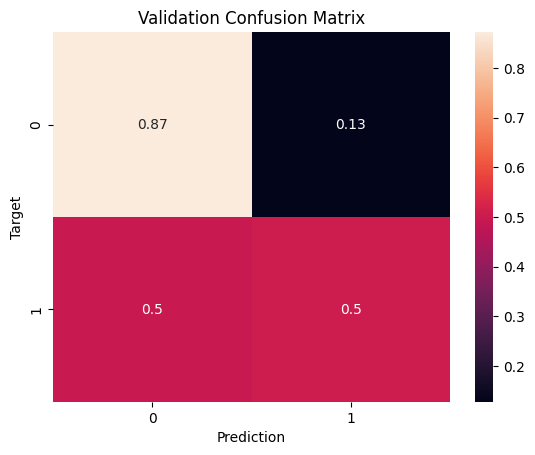

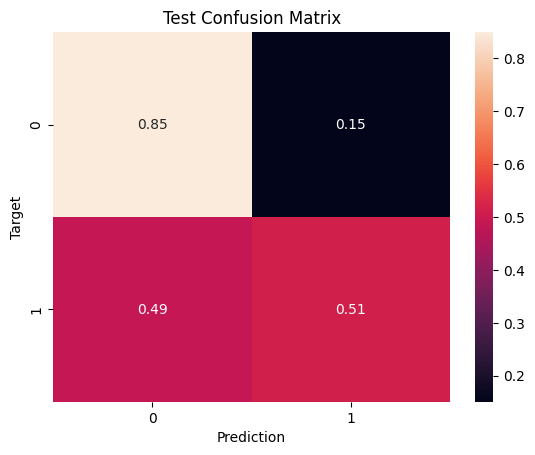

In [6]:
# Select the columns to be used for training/prediction
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]
from sklearn.tree import DecisionTreeClassifier

# Create and train the model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, train_targets)
from sklearn.metrics import accuracy_score,confusion_matrix
# Generate predictions and probabilities
train_preds = model.predict(X_train)
train_probs = model.predict_proba(X_train)
accuracy_score(train_targets, train_preds)

# Helper function to predict, compute accuracy & plot confustion matrix
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));    
    return preds

# Evaluate on validation and test set
val_preds = predict_and_plot(X_val, val_targets, 'Validation')
test_preds = predict_and_plot(X_test, test_targets, 'Test')




In [7]:
from sklearn.tree import plot_tree,export_text

[Text(0.5, 0.875, 'Humidity3pm <= 0.715\ngini = 0.346\nsamples = 97988\nvalue = [76190, 21798]'),
 Text(0.25, 0.625, 'Humidity3pm <= 0.512\ngini = 0.244\nsamples = 81588\nvalue = [69975, 11613]'),
 Text(0.125, 0.375, 'Sunshine <= 0.525\ngini = 0.142\nsamples = 47657\nvalue = [43985.0, 3672.0]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'WindGustSpeed <= 0.333\ngini = 0.359\nsamples = 33931\nvalue = [25990, 7941]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Humidity3pm <= 0.825\ngini = 0.471\nsamples = 16400\nvalue = [6215, 10185]'),
 Text(0.625, 0.375, 'Rainfall <= 0.007\ngini = 0.499\nsamples = 9053\nvalue = [4772, 4281]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Rainfall <= 0.009\ngini = 0.316\nsamples = 7347\nvalue = [1443, 5904]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

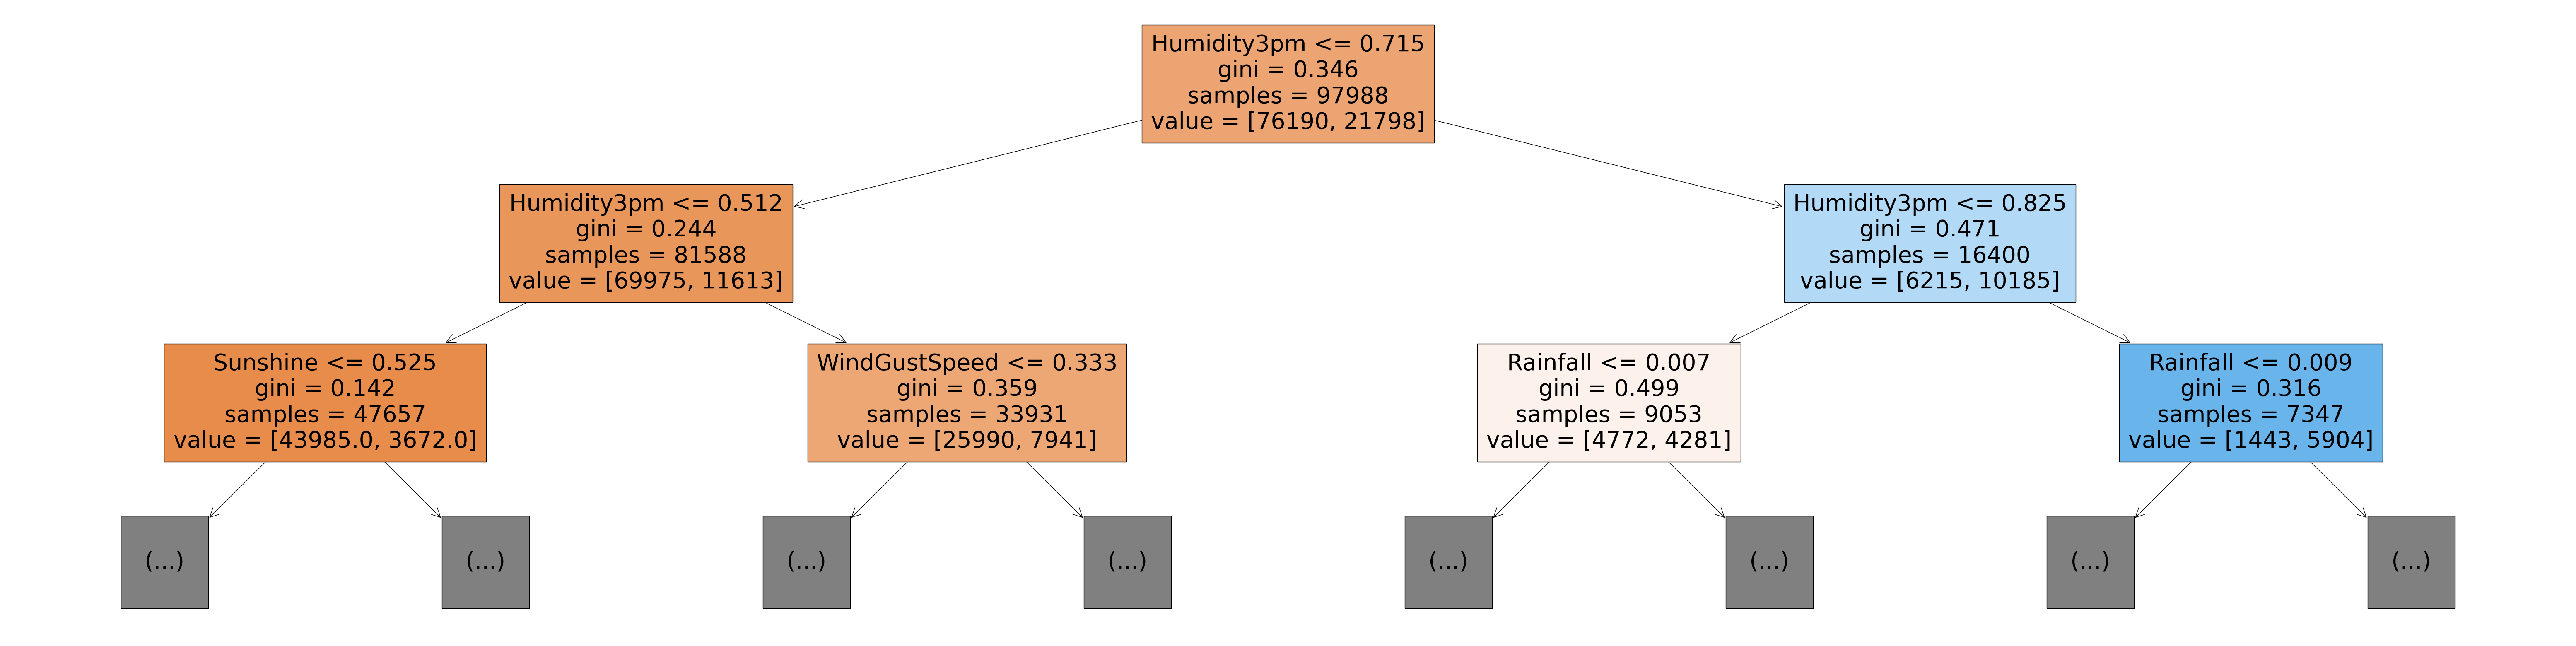

In [8]:
plt.figure(figsize=(80, 20))
plot_tree(model,feature_names=X_train.columns , max_depth=2 ,filled=True)

In [9]:
model.tree_.max_depth

46

In [10]:
model.feature_importances_

array([0.04122558, 0.03887034, 0.04342705, 0.02320953, 0.04833551,
       0.06126003, 0.02775848, 0.03084026, 0.03942103, 0.28006643,
       0.03794535, 0.06472083, 0.01474074, 0.0170647 , 0.03865482,
       0.00175004, 0.00175879, 0.00105707, 0.00077429, 0.00163299,
       0.0012234 , 0.00110259, 0.0016417 , 0.00082906, 0.00135243,
       0.00086679, 0.00199216, 0.00153714, 0.00059082, 0.00053696,
       0.00174686, 0.00036217, 0.00133534, 0.00111447, 0.00137645,
       0.00080351, 0.00088233, 0.00149152, 0.00153823, 0.00045646,
       0.00082857, 0.0012906 , 0.00166659, 0.00117223, 0.00074088,
       0.0008236 , 0.00151218, 0.00145357, 0.00204653, 0.0010623 ,
       0.00167803, 0.00140233, 0.00269009, 0.00105264, 0.00034997,
       0.00156362, 0.00035757, 0.00116023, 0.00167361, 0.00140207,
       0.00141996, 0.00261102, 0.00167526, 0.00060368, 0.00236287,
       0.00179357, 0.00212899, 0.00327601, 0.00278792, 0.00192528,
       0.00323519, 0.00267314, 0.00248498, 0.00231233, 0.00224

In [11]:
importance_df = pd.DataFrame({
    'feature':X_train.columns,
    'importance':model.feature_importances_
    
}).sort_values('importance', ascending=False)

In [12]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.280066
11,Pressure3pm,0.064721
5,WindGustSpeed,0.061260
4,Sunshine,0.048336
2,Rainfall,0.043427
0,MinTemp,0.041226
8,Humidity9am,0.039421
1,MaxTemp,0.038870
14,Temp9am,0.038655
10,Pressure9am,0.037945


<Axes: title={'center': 'feature importance'}, xlabel='importance', ylabel='feature'>

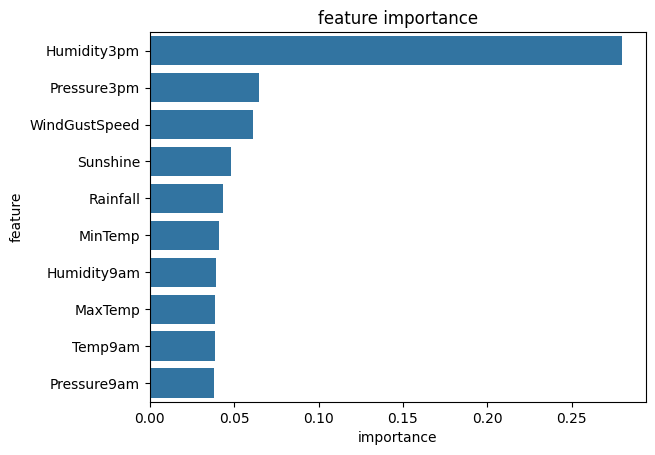

In [13]:
plt.title('feature importance')
sns.barplot(data = importance_df.head(10), x = 'importance' , y = 'feature')

In [14]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)

In [15]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [16]:
model.score(X_train, train_targets)

0.8315916234640977

In [17]:
model.score(X_val,val_targets)

0.8348060155655685

In [18]:
model.score(X_test,test_targets)

0.8218591987553481

In [19]:
print(export_text(model , feature_names=list(X_train.columns)))

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Sunshine <= 0.53
|   |   |   |--- class: No
|   |   |--- Sunshine >  0.53
|   |   |   |--- class: No
|   |--- Humidity3pm >  0.51
|   |   |--- WindGustSpeed <= 0.33
|   |   |   |--- class: No
|   |   |--- WindGustSpeed >  0.33
|   |   |   |--- class: No
|--- Humidity3pm >  0.72
|   |--- Humidity3pm <= 0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- class: No
|   |   |--- Rainfall >  0.01
|   |   |   |--- class: Yes
|   |--- Humidity3pm >  0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- class: Yes
|   |   |--- Rainfall >  0.01
|   |   |   |--- class: Yes



In [20]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md , random_state=42)
    model.fit(X_train, train_targets)
    train_error = 1-model.score(X_train, train_targets)
    val_error= 1-model.score(X_val,val_targets )
    return {'Max depth ': md , 'training error': train_error , 'validation error' : val_error} 

In [21]:

errors_df = pd.DataFrame([max_depth_error(md) for md in range(1,21)])


In [22]:
errors_df

,Max depth,training error,validation error
0,1,0.181941,0.176488
1,2,0.176930,0.170695
2,3,0.168408,0.165194
3,4,0.162153,0.161624
4,5,0.157244,0.158113
5,6,0.153131,0.155890
6,7,0.149120,0.154836
7,8,0.144916,0.154368
8,9,0.139619,0.154544
9,10,0.132057,0.155656


In [23]:
plt.figure()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

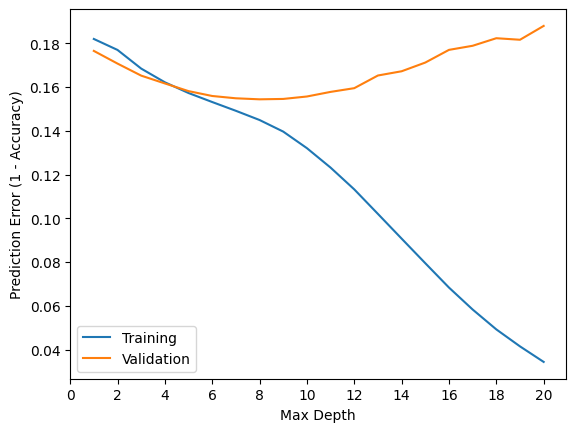

In [24]:
plt.plot(errors_df['Max depth '], errors_df['training error'])
plt.plot(errors_df['Max depth '], errors_df['validation error'])
plt.xticks(range(0, 21, 2))
plt.xlabel('Max Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])
plt.show()


In [25]:
model = DecisionTreeClassifier(max_depth=7, random_state=42).fit(X_train, train_targets)

In [26]:
model.score(X_val, val_targets) ,model.score(X_test, test_targets)

(0.8451635555035403, 0.8334500194476857)

In [27]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)
model.fit(X_train, train_targets)  
model.fit(X_val, val_targets)
model.fit(X_test, test_targets)

DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [28]:
model.score(X_test, test_targets)

0.8572150914041229

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
model = RandomForestClassifier(n_jobs=-1 , random_state=42)

In [31]:
model.fit(X_train, train_targets)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [32]:
model.score(X_train , train_targets)

0.9999693840062048

In [33]:
model.score(X_val, val_targets)

0.8565744045877465

In [34]:
model.score(X_test,test_targets )

0.8457409568261377

In [35]:
train_probs = model.predict_proba(X_train)

In [36]:
train_probs

array([[0.96, 0.04],
       [0.97, 0.03],
       [0.98, 0.02],
       ...,
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.96, 0.04]])

In [37]:
importance_df = pd.DataFrame({
    'feature':X_train.columns,
    'importance':model.feature_importances_
    
}).sort_values('importance', ascending=False)
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.149998
11,Pressure3pm,0.054639
4,Sunshine,0.054286
8,Humidity9am,0.053871
5,WindGustSpeed,0.050907
10,Pressure9am,0.050807
2,Rainfall,0.046521
1,MaxTemp,0.046347
0,MinTemp,0.042834
14,Temp9am,0.041120


<Axes: title={'center': 'feature importance'}, xlabel='importance', ylabel='feature'>

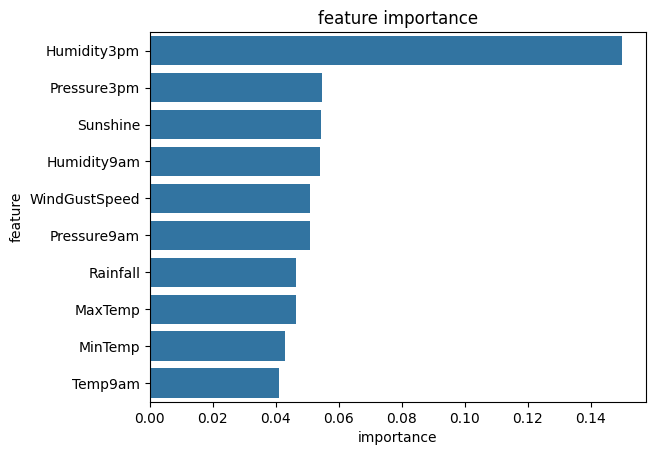

In [38]:
plt.title('feature importance')
sns.barplot(data = importance_df.head(10), x = 'importance' , y = 'feature')

In [39]:
base_model = RandomForestClassifier(random_state=42,n_jobs=-1).fit(X_train, train_targets)

In [40]:
base_train_acc = base_model.score(X_train, train_targets)
base_val_acc =  base_model.score(X_val, val_targets)

In [41]:
base_accs = base_train_acc, base_val_acc

In [42]:
base_accs

(0.9999693840062048, 0.8565744045877465)

In [43]:
model = RandomForestClassifier(random_state=42, n_jobs=-1 , n_estimators=500)
model.fit(X_train ,train_targets)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [44]:
model.score(X_train, train_targets)

0.9999795893374699

In [45]:
model.score(X_val, val_targets)

0.8574521622096085

In [46]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42 , n_jobs=1,**params).fit(X_train, train_targets )
    return model.score(X_train, train_targets ),model.score(X_val, val_targets)

In [47]:
test_params(max_depth =  5)

(0.8283157121280157, 0.8321142255251917)

In [48]:
test_params(max_depth = 26)

(0.9814875290851941, 0.8563403358885833)

In [49]:
test_params(max_leaf_nodes = 2**5)

(0.834551169530963, 0.8356252560126397)

In [50]:
test_params(max_leaf_nodes = 2**20 )

(0.9999795893374699, 0.8579788167827257)

In [51]:
base_accs

(0.9999693840062048, 0.8565744045877465)

In [52]:
test_params(max_features=3)

(0.9999795893374699, 0.8538240973725788)

In [54]:
test_params(max_features = 20)

(0.9999795893374699, 0.8575691965591902)

In [55]:
base_accs

(0.9999693840062048, 0.8565744045877465)

In [59]:
X_train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm',
       ...
       'WindDir3pm_SE', 'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW',
       'WindDir3pm_W', 'WindDir3pm_WNW', 'WindDir3pm_WSW', 'WindDir3pm_nan',
       'RainToday_No', 'RainToday_Yes'],
      dtype='object', length=117)

In [61]:
test_params(min_samples_split  = 100 , min_samples_leaf = 60)

(0.8510123688614932, 0.8472701737960091)

In [62]:
test_params(min_samples_split  = 10 , min_samples_leaf = 60)

(0.8510123688614932, 0.8472701737960091)

In [63]:
base_accs

(0.9999693840062048, 0.8565744045877465)

In [65]:
test_params(min_impurity_decrease = 1e-7)

(0.9994897334367474, 0.8579202996079349)

In [66]:
test_params(min_impurity_decrease = 1e-2)

(0.7775441890843777, 0.7906255485985136)

In [67]:
base_accs

(0.9999693840062048, 0.8565744045877465)

In [68]:
test_params(bootstrap = False)

(0.9999795893374699, 0.857627713733981)

In [69]:
base_accs

(0.9999693840062048, 0.8565744045877465)

In [70]:
test_params(max_samples=0.9)

(0.9998163040372291, 0.857627713733981)

In [71]:
base_accs

(0.9999693840062048, 0.8565744045877465)

In [72]:
train_targets.value_counts()/len(train_targets)

No     0.777544
Yes    0.222456
Name: RainTomorrow, dtype: float64

In [73]:
model.classes_

array(['No', 'Yes'], dtype=object)

In [74]:
test_params(class_weight = 'balanced')

(0.9999693840062048, 0.8564573702381649)

In [75]:
test_params(class_weight = {'No' : 1 , 'Yes':2})

(0.9999795893374699, 0.8559307156650476)

In [76]:
base_accs

(0.9999693840062048, 0.8565744045877465)

In [81]:
model = RandomForestClassifier(n_jobs  = -1 , random_state = 42, n_estimators=500, max_features=7 ,max_depth=30 , class_weight={'No' : 1 , 'Yes' : 3}
)


In [82]:
model.fit(X_train, train_targets)

RandomForestClassifier(class_weight={'No': 1, 'Yes': 3}, max_depth=30,
                       max_features=7, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [83]:
model.score(X_train, train_targets) ,model.score(X_val, val_targets)

(0.9960301261378944, 0.8575691965591902)

In [84]:
base_accs

(0.9999693840062048, 0.8565744045877465)

In [85]:
model.score(X_test, test_targets)

0.846246596654998

In [86]:
import joblib

In [88]:
aussie_rain ={ 'model' : model, 'imputer' : imputer, 'scaler' : scaler , 'encoder':encoder, 'input_cols' : input_cols ,'target_col':target_col , 'numeric_cols' : numeric_cols, 'categorical_cols': categorical_cols, 'encoded_cols': encoded_cols }
    


In [89]:
joblib.dump(aussie_rain ,'aussie_rain.joblib')

['aussie_rain.joblib']

In [90]:
aussie_rain2 = joblib.load('aussie_rain.joblib')

In [91]:
test_preds2 = aussie_rain2['model'].predict(X_test)
accuracy_score(test_targets, test_preds2)

0.846246596654998